# Задание 2 по дисциплине машинное обучение для анализа научных данных

## Самсонов Александр Александрович

## Ход работы

Для этой работы я выбрал датасет [spaceship titanic](https://www.kaggle.com/competitions/spaceship-titanic) с kaggle. Он содержит в себе категориальные и количественные метрики. Задача заключается в бинарной классификации.

Целевая категория - был ли перемещен человек в хаос, или нет. Категории сбалансированны. Для оценки я применял AUC (по умолчанию) на обучении по пресету и f1, при оптимизации параметров.

Я выбрал модель tensorflow_decision_forests.keras.GradientBoostedTreesModel, так как я хотел потрогать библиотеку keras (ну и немного пострадать).

Первый шаг обучения - получить, что я бы назвал, продвинутый бейслайн: обучить модель с пресетом гиперпараметров. Далее я создал task обучения при помощи optuna и получил результат... Хуже. Либо я неправильно предобработал данные, либо просто таковы данные. Кросс-валидация осуществлятся автоматически алгоритмами обучения tensorflow

Вся работа выполнялась в среде collab, я не делал настройки для локального запуска.

## Вывод

Я поработал с моделями на остове деревьев выбора в библиотеке keras. Также я использовал инструментарий optuna для оптимизации параметров. У tensorflow поразительно оптимально даны гиперпараметры.

## Примечания

random state 42 оказался поразительно неоптимальным. Обычно я получал f1 в диапазоне 0.8-0.85

# Импорты и загрузка данных

In [1]:
%%capture
%pip install opendatasets
%pip install tensorflow tensorflow_decision_forests
%pip install optuna

In [2]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import opendatasets as od

from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier

import optuna
import random


np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [3]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.15.0
TensorFlow Decision Forests v1.8.1


In [4]:
od.download("https://www.kaggle.com/competitions/spaceship-titanic")

Skipping, found downloaded files in "./spaceship-titanic" (use force=True to force download)


In [5]:
dataset_df = pd.read_csv('./spaceship-titanic/train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (8693, 14)


In [6]:
dataset_df.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
304,0337_02,Mars,False,F/63/S,TRAPPIST-1e,19.0,False,417.0,349.0,634.0,3.0,1057.0,Weros Perle,True
2697,2891_01,Earth,False,G/460/S,TRAPPIST-1e,18.0,False,4.0,904.0,0.0,0.0,1.0,Gleney Ortinericey,False
8424,8998_01,Earth,True,G/1449/S,TRAPPIST-1e,41.0,False,0.0,0.0,0.0,0.0,0.0,Gerry Englence,False
1672,1771_01,Earth,False,G/291/P,TRAPPIST-1e,35.0,False,0.0,338.0,436.0,NaN,0.0,Antone Cardner,True
8458,9034_02,Europa,True,D/288/P,TRAPPIST-1e,43.0,False,0.0,0.0,0.0,0.0,0.0,Errairk Crakete,True


12 категорий, целевая - transported

# Быстрый осмотр данных

In [7]:
dataset_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [8]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [9]:
dataset_df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

## Визуализация

<Axes: >

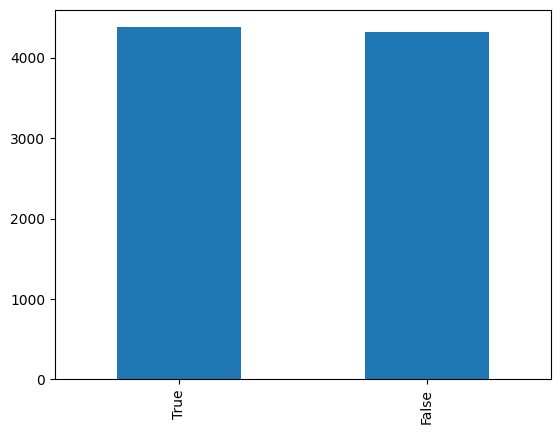

In [10]:
plot_df = dataset_df.Transported.value_counts()
plot_df.plot(kind="bar")

Мило, распределение почти 50/50

### Посмотрим распределение численных данных

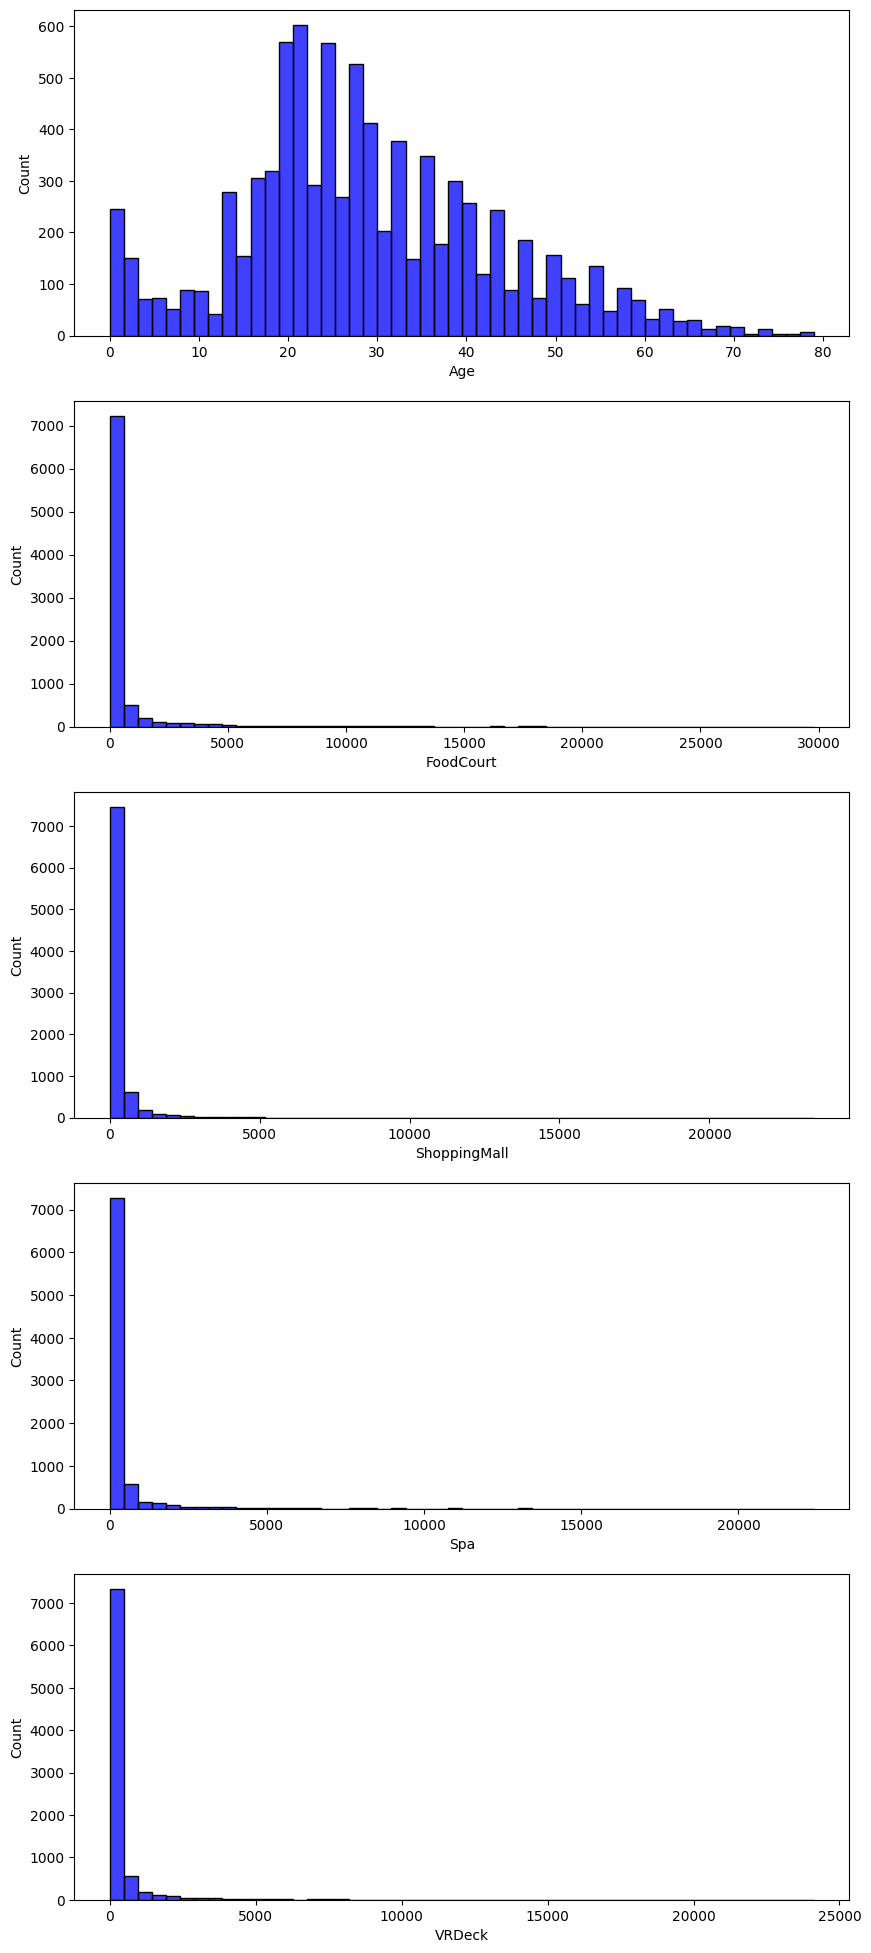

In [11]:
fig, ax = plt.subplots(5,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)

sns.histplot(dataset_df['Age'], color='b', bins=50, ax=ax[0]);
sns.histplot(dataset_df['FoodCourt'], color='b', bins=50, ax=ax[1]);
sns.histplot(dataset_df['ShoppingMall'], color='b', bins=50, ax=ax[2]);
sns.histplot(dataset_df['Spa'], color='b', bins=50, ax=ax[3]);
sns.histplot(dataset_df['VRDeck'], color='b', bins=50, ax=ax[4]);

# Предобработка

Удалим имя, оно точно не поможет
Нам не требуется заполнять нули, так как decision forest умеет с ними обращаться

In [12]:
dataset_df = dataset_df.drop(['Name'], axis=1)
dataset_df.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [13]:
dataset_df.isnull().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64

В датасете содержатся количественные и качественные данные. TF-DF способен работать с ними, но не с булевыми полями. Надо закодировать их в `int`. Остутствующие - заменим 0

Остальные null значения оставим алгоритму на откуп

In [14]:
dataset_df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = dataset_df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(value=0)
dataset_df.isnull().sum().sort_values(ascending=False)

HomePlanet      201
Cabin           199
Destination     182
RoomService     181
Age             179
PassengerId       0
CryoSleep         0
VIP               0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
dtype: int64

In [15]:
dataset_df[['CryoSleep', 'VIP', 'Transported']] = dataset_df[['CryoSleep', 'VIP', 'Transported']].astype(int)

Колонка `Cabin` соответствует кодировке `Deck/Cabin_num/Side`. Разделим ее, чтобы у модели было больше информации

In [16]:
dataset_df[["Deck", "Cabin_num", "Side"]] = dataset_df["Cabin"].str.split("/", expand=True)

In [17]:
try:
    dataset_df = dataset_df.drop('Cabin', axis=1)
except KeyError:
    print("Field does not exist")

Сделаем подобное с PassangerID

In [18]:
dataset_df[["group", "ID"]] = dataset_df["PassengerId"].str.split("_", expand=True)

Заменим group на количество людей в группе

In [19]:
dataset_df['group_count'] = dataset_df.groupby('group')['group'].transform('count')

dataset_df.drop(["group", "PassengerId"], inplace=True, axis=1)

In [20]:
dataset_df


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side,ID,group_count
0,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0,B,0,P,01,1
1,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1,F,0,S,01,1
2,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,A,0,S,01,2
3,Europa,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,A,0,S,02,2
4,Earth,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,1,F,1,S,01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,0,55 Cancri e,41.0,1,0.0,6819.0,0.0,1643.0,74.0,0,A,98,P,01,1
8689,Earth,1,PSO J318.5-22,18.0,0,0.0,0.0,0.0,0.0,0.0,0,G,1499,S,01,1
8690,Earth,0,TRAPPIST-1e,26.0,0,0.0,0.0,1872.0,1.0,0.0,1,G,1500,S,01,1
8691,Europa,0,55 Cancri e,32.0,0,0.0,1049.0,0.0,353.0,3235.0,0,E,608,S,01,2


In [21]:
dataset_df["ID"] = dataset_df["ID"].astype(int)

Сконвертируем планеты и за-одно заменим side на int

In [22]:
dataset_df[["HomePlanet0", "HomePlanet1", "HomePlanet2", "_"]] = LabelBinarizer().fit_transform(dataset_df["HomePlanet"].astype(str))
dataset_df[["Destination0", "Destination1", "Destination2", "_"]] = LabelBinarizer().fit_transform(dataset_df["Destination"].astype(str))

In [23]:
dataset_df.drop(["Destination", "HomePlanet", "_", "Cabin_num"], axis=1, inplace=True)

In [24]:
dataset_df["Side"] = ((dataset_df["Side"]) == "S").astype(int)

In [25]:
dataset_df["Deck"] = dataset_df["Deck"].astype(str).apply(lambda x: ord(x)-ord("A") if x != "nan" else 5)

In [26]:
dataset_df

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Side,ID,group_count,HomePlanet0,HomePlanet1,HomePlanet2,Destination0,Destination1,Destination2
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,0,1,1,0,1,0,0,0,1
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,5,1,1,1,1,0,0,0,0,1
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0,1,1,2,0,1,0,0,0,1
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0,1,2,2,0,1,0,0,0,1
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,5,1,1,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,0,0,0,1,1,0,1,0,1,0,0
8689,1,18.0,0,0.0,0.0,0.0,0.0,0.0,0,6,1,1,1,1,0,0,0,1,0
8690,0,26.0,0,0.0,0.0,1872.0,1.0,0.0,1,6,1,1,1,1,0,0,0,0,1
8691,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,0,4,1,1,2,0,1,0,1,0,0


Переведем `pd.DataFrame` в `tf.data.Dataset`

[TensorFlow Datasets](https://www.tensorflow.org/datasets/overview) оптимизированы для работы на видеокартах и прочих TPU.

In [27]:
ratio = 0.8
label = "Transported"

test_indices = np.random.rand(len(dataset_df)) < ratio
test, train = dataset_df[~test_indices], dataset_df[test_indices]

In [28]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label=label)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, label=label)

# Модели

Ниже список моделей на основе деревьев, которые есть в keras

* RandomForestModel
* GradientBoostedTreesModel
* CartModel
* DistributedGradientBoostedTreesModel

In [29]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

## Настраиваем

TensorFlow Decision Forests идет сразу с оптимизированными параметрами для средней задачи.

Можно выбрать из шаблонов


```
rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1")
```

Больше [тут](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel).

Попробуем пока с ним

In [30]:
rf = tfdf.keras.GradientBoostedTreesModel()
rf.compile(metrics=["f1"])

Use /tmp/tmpjyu5r54j as temporary training directory


## Тренируем

In [31]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:05.062409. Found 6961 examples.
Training model...
Model trained in 0:00:03.146056
Compiling model...
Model compiled.


# Визуализация
Ради интереса, изучим встроеными методами, к каким выводам пришло наше дерево

In [32]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

# Оценим работу модели без подбора гиперпараметров

Можно за-одно оценить как развивалась модели, посмотрев ее логи


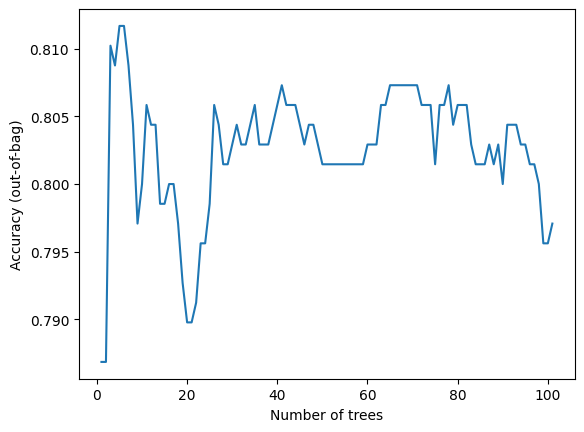

In [33]:
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.show()

In [34]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=None, accuracy=0.8072992563247681, loss=0.7853006720542908, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

Accuracy не очень высокий, похоже что модель не переобучилась

In [35]:
y_pred = rf.predict(valid_ds).round()

f1_score(test[label], y_pred)

2/2 [==============================] - 0s 13ms/step


0.7935267857142857

f1 не очень и высокий. Определенно необходима оптимизация

In [36]:
def objective(trial):
    model = tfdf.keras.GradientBoostedTreesModel(
        num_trees=trial.suggest_int("num_trees", 100, 500),
        max_depth=trial.suggest_int("max_depth", 3, 10),
        shrinkage=trial.suggest_float("shrinkage", 0.01, 0.3),
        min_examples=trial.suggest_int("min_examples", 2, 20),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        l1_regularization=trial.suggest_float("l1_regularization", 0.0, 1.0),
        l2_regularization=trial.suggest_float("l2_regularization", 0.0, 1.0),
        early_stopping="LOSS_INCREASE",
        early_stopping_num_trees_look_ahead=trial.suggest_int("early_stopping_num_trees_look_ahead", 10, 50)
    )

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss='binary_crossentropy',
                    metrics=[tf.keras.metrics.AUC()])

    model.fit(train_ds, epochs=1, verbose=0)

    predictions = model.predict(valid_ds)

    y_true = test[label]
    y_pred = predictions > 0.5
    score = f1_score(y_true, y_pred)

    return score

In [37]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print('Best trial:', study.best_trial.params)

[I 2024-02-13 09:01:52,558] A new study created in memory with name: no-name-eaa51146-561c-4832-b0c8-9b6656d2dc60


Use /tmp/tmpa__uibaj as temporary training directory
2/2 [==============================] - 0s 15ms/step


[I 2024-02-13 09:01:55,076] Trial 0 finished with value: 0.7960088691796009 and parameters: {'num_trees': 441, 'max_depth': 5, 'shrinkage': 0.18174580750526134, 'min_examples': 17, 'subsample': 0.6419976192954513, 'l1_regularization': 0.6411352143523351, 'l2_regularization': 0.6549393401749102, 'early_stopping_num_trees_look_ahead': 37}. Best is trial 0 with value: 0.7960088691796009.


Use /tmp/tmpf83qivb2 as temporary training directory


2/2 [==============================] - 0s 22ms/step


[I 2024-02-13 09:01:59,716] Trial 1 finished with value: 0.7951002227171493 and parameters: {'num_trees': 232, 'max_depth': 5, 'shrinkage': 0.05151041246438337, 'min_examples': 14, 'subsample': 0.736514877167066, 'l1_regularization': 0.7977764806601689, 'l2_regularization': 0.22138093020712657, 'early_stopping_num_trees_look_ahead': 23}. Best is trial 0 with value: 0.7960088691796009.


Use /tmp/tmpn40utck2 as temporary training directory
2/2 [==============================] - 0s 10ms/step


[I 2024-02-13 09:02:05,799] Trial 2 finished with value: 0.7895037079292642 and parameters: {'num_trees': 252, 'max_depth': 10, 'shrinkage': 0.19102538499921395, 'min_examples': 8, 'subsample': 0.8981887641413415, 'l1_regularization': 0.5951544544832125, 'l2_regularization': 0.09322612691937981, 'early_stopping_num_trees_look_ahead': 19}. Best is trial 0 with value: 0.7960088691796009.


Use /tmp/tmp5fw6jfwv as temporary training directory


2/2 [==============================] - 0s 9ms/step


[I 2024-02-13 09:02:08,664] Trial 3 finished with value: 0.7950727883538634 and parameters: {'num_trees': 334, 'max_depth': 4, 'shrinkage': 0.10321536209099673, 'min_examples': 14, 'subsample': 0.9738376413583858, 'l1_regularization': 0.2804049247257546, 'l2_regularization': 0.6690865598499659, 'early_stopping_num_trees_look_ahead': 45}. Best is trial 0 with value: 0.7960088691796009.


Use /tmp/tmpzlulzgop as temporary training directory


2/2 [==============================] - 0s 8ms/step


[I 2024-02-13 09:02:09,945] Trial 4 finished with value: 0.7928928373126041 and parameters: {'num_trees': 350, 'max_depth': 3, 'shrinkage': 0.2154569536548685, 'min_examples': 4, 'subsample': 0.9772266114347749, 'l1_regularization': 0.2178002960527713, 'l2_regularization': 0.8323780961198104, 'early_stopping_num_trees_look_ahead': 20}. Best is trial 0 with value: 0.7960088691796009.


Use /tmp/tmpbficqswh as temporary training directory
2/2 [==============================] - 0s 12ms/step


[I 2024-02-13 09:02:11,577] Trial 5 finished with value: 0.7944598337950138 and parameters: {'num_trees': 219, 'max_depth': 3, 'shrinkage': 0.07992863513729652, 'min_examples': 5, 'subsample': 0.6066350277001616, 'l1_regularization': 0.4680162386695266, 'l2_regularization': 0.5597464290772936, 'early_stopping_num_trees_look_ahead': 49}. Best is trial 0 with value: 0.7960088691796009.


Use /tmp/tmpagdol8js as temporary training directory
2/2 [==============================] - 0s 6ms/step


[I 2024-02-13 09:02:14,566] Trial 6 finished with value: 0.7957824639289679 and parameters: {'num_trees': 452, 'max_depth': 5, 'shrinkage': 0.25379807201000654, 'min_examples': 16, 'subsample': 0.7350642986599261, 'l1_regularization': 0.26832430562149445, 'l2_regularization': 0.18447799336906878, 'early_stopping_num_trees_look_ahead': 41}. Best is trial 0 with value: 0.7960088691796009.


Use /tmp/tmp4ievlo86 as temporary training directory
2/2 [==============================] - 0s 9ms/step


[I 2024-02-13 09:02:16,441] Trial 7 finished with value: 0.7975253093363329 and parameters: {'num_trees': 281, 'max_depth': 6, 'shrinkage': 0.27050806965025437, 'min_examples': 3, 'subsample': 0.9306711072546191, 'l1_regularization': 0.8911693529171639, 'l2_regularization': 0.5968456222092757, 'early_stopping_num_trees_look_ahead': 35}. Best is trial 7 with value: 0.7975253093363329.


Use /tmp/tmpdzkxsh10 as temporary training directory
2/2 [==============================] - 0s 10ms/step


[I 2024-02-13 09:02:18,108] Trial 8 finished with value: 0.7948574622694242 and parameters: {'num_trees': 247, 'max_depth': 5, 'shrinkage': 0.13041201265805522, 'min_examples': 7, 'subsample': 0.6878118720888315, 'l1_regularization': 0.6701624406297738, 'l2_regularization': 0.42620127231642, 'early_stopping_num_trees_look_ahead': 19}. Best is trial 7 with value: 0.7975253093363329.


Use /tmp/tmpo2_wx5w4 as temporary training directory
2/2 [==============================] - 0s 9ms/step


[I 2024-02-13 09:02:19,661] Trial 9 finished with value: 0.7935805201992253 and parameters: {'num_trees': 344, 'max_depth': 4, 'shrinkage': 0.16797823349797522, 'min_examples': 4, 'subsample': 0.6490721873456747, 'l1_regularization': 0.3171706530476357, 'l2_regularization': 0.13913788577213937, 'early_stopping_num_trees_look_ahead': 15}. Best is trial 7 with value: 0.7975253093363329.


Best trial: {'num_trees': 281, 'max_depth': 6, 'shrinkage': 0.27050806965025437, 'min_examples': 3, 'subsample': 0.9306711072546191, 'l1_regularization': 0.8911693529171639, 'l2_regularization': 0.5968456222092757, 'early_stopping_num_trees_look_ahead': 35}


Грустно, но как есть. Вероятно, более простые модели справились бы лучше? Посмотрим

In [38]:
X_train, X_test, y_train, y_test = train_test_split(dataset_df.dropna().drop(label, axis=1),
                                                    dataset_df.dropna()[label])


model_params = {
    SVC: {
        'C':[1,  0.1, 0.01, 0.001],
        'gamma':[1,0.1,0.001,0.0001]
    },
    LinearSVC: {
        'C':[1,10,100,1000],
        "loss": ["hinge", "squared_hinge"]
    },
}

svc_grid = GridSearchCV(
    SVC(),
    param_grid = model_params[SVC],
    scoring="f1",
    cv=3,
    refit=True,
    n_jobs=-1
)

linear_svc_grid = GridSearchCV(
    LinearSVC(),
    param_grid = model_params[LinearSVC],
    scoring="f1",
    cv=3,
    refit=True,
    n_jobs=-1
)

In [39]:
print(f"svc slightly tuned {print(svc_grid.fit(X_train, y_train).score(X_test, y_test))}")
print(f"linear svc slightly tuned {print(linear_svc_grid.fit(X_train, y_train).score(X_test, y_test))}")
print(f"Dummy classifyer for fun: {f1_score(y_test, DummyClassifier().fit(X=X_train, y=y_train).predict(X_test))}")

0.7569913211186113
svc slightly tuned None
0.7382602001539648
linear svc slightly tuned None
Dummy classifyer for fun: 0.6649583600256246


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Не идеальное сравнение, но какое есть. Я сделал очень много допущений, не подготовил данные для этих алгоритмов и так далее. Видимо, результат f1 $\approx$ 0.8 - лучшее, что я сейчас могу получить.

# Интерпретация

In [40]:
best_params = study.best_trial.params

tuned_tf_model = tfdf.keras.GradientBoostedTreesModel(**best_params)
tuned_tf_model.compile()
tuned_tf_model.fit(train_ds)

Use /tmp/tmpttvj910g as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.290914. Found 6961 examples.
Training model...
Model trained in 0:00:01.141774
Compiling model...
Model compiled.


In [41]:
tfdf.model_plotter.plot_model_in_colab(tuned_tf_model, tree_idx=0, max_depth=4)

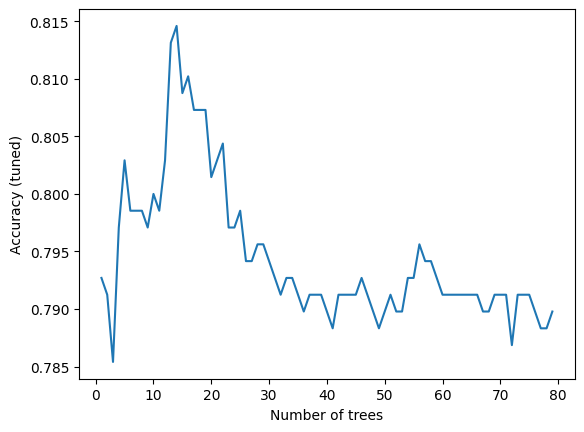

In [42]:
logs = tuned_tf_model.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (tuned)")
plt.show()

Как мы видим, данная проблема лучше всего себя показала на количестве деревьев в районе 20. "основанием" для дерева является параметр, был ли человек погружен в сон. Очень логично распределены последующие 2 уровня:
- у спящих -  планета, откуда они
- у остальных - их траты

Дополнительное преимущество у визуализаций - отлов лишних параметров, попавших в модель и переобучивших ее.